In [1]:
import pandas as pd
import numpy as np, matplotlib.pyplot as plt
from pprint import pprint
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing 
from sklearn.metrics import accuracy_score, mean_squared_error, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
import pickle

In this work , we solve a reinforcement learning case study for Axa. We are asked to implement a Q-learning algorithm.
The objective is to find a suitable strategy per customer contract to maximize Gain and minimize Cost according to the characteristics of the customer.

In this part, we are going to build 3 predictive models: each one for each strategy. the model will predict if a strategy will succeed when applied to a customer. 

Those models will allow us to simulate customer reactions to strategy and to perform episodic simulations in the Q-learning setting.

We tried a unique model for the 3 strategies with the strategy given as an input but we got poor result due to the fact that the model cannot find a correlation  between strategy and succes when all 3 are in the same historical data

In [11]:
# Importing Data

train=pd.read_csv('C:/Users/Caliméromaric/Downloads/train.csv',  sep=';' , decimal=',') 

test = pd.read_csv('C:/Users/Caliméromaric/Downloads/test.csv',  sep=';' , thousands=',') 

# Lets see how the data looks like
print (train.head())

# Data Preprocessing : 

#removing the dot decimal separator 
train['G'] = [x.replace(',', '.') for x in train['G']]

# converting the column to float type
train['G'] =train['G'].astype(float)

# Lets see how the data looks like now
print (train.head())

   Day  A     B  C  D   E  F        G  H  I  ...  W         X   Y   Z     AA  \
0    3  0  book  0  4  32  2  10.0000  6  0  ...  5 -6.262788   4   0  poire   
1    1  0  book  0  4  30  3   5.0000  5  0  ...  1 -6.176597  15  12  pomme   
2    3  0  book  0  4  31  3  10.0000  6  0  ...  5 -6.309625   0  13  pomme   
3    3  0   pen  1  4  32  3  10.0000  6  1  ...  1 -6.274018   1  13  prune   
4    2  0  book  0  4  30  3  10.0000  6  0  ...  1 -6.270903   2  11  pomme   

     BB  Gain  Cost  Strategy  Success  
0  0.39  82.0  65.0         0        0  
1  0.87  42.0  28.0         1        0  
2  1.00  94.0  78.0         2        0  
3  0.79  53.0  37.0         0        0  
4  0.87  56.0  55.0         1        0  

[5 rows x 33 columns]
   Day  A     B  C  D   E  F     G  H  I  ...  W         X   Y   Z     AA  \
0    3  0  book  0  4  32  2  10.0  6  0  ...  5 -6.262788   4   0  poire   
1    1  0  book  0  4  30  3   5.0  5  0  ...  1 -6.176597  15  12  pomme   
2    3  0  book  0 

In [12]:
# Making sure all columns are from the correct type
train.dtypes

Day           int64
A             int64
B            object
C             int64
D             int64
E             int64
F             int64
G           float64
H             int64
I             int64
J             int64
K             int64
L             int64
M             int64
N             int64
O             int64
P             int64
Q             int64
R             int64
S             int64
T           float64
U             int64
V             int64
W             int64
X           float64
Y             int64
Z             int64
AA           object
BB          float64
Gain        float64
Cost        float64
Strategy      int64
Success       int64
dtype: object

In [13]:
# Copying the data in a working df and encoding categorical columns
df = train.copy()
df[['AA', 'B'  ] ] = df[['AA', 'B'  ] ].apply(preprocessing.LabelEncoder().fit_transform) # We dont need one hot encoding for Random Forest




70 % of of customers responds negatively to the strategy applied. We have an imbalanced class problem. A workaround is to remove a part of the Success= 0  data to rebalance the classes. (We tried without doing so and we obtained a lazy model with 70 % accuracy always predicting 0)

In [17]:

# Rebalancing classes 

df.drop(df[df.Success == 0].sample(n=1500, replace=False).index, inplace = True)

We choose a random forest model because it usually performs well on structured data and it is relatively simple ( compared to Grad Boost for ex ) . We could have tried other models , like xGboost or SVM to fetch a better predictive performance

We manually tuned the hyperparameters. We dont want a fully grown tree to prevent overfitting . We control this by limiting min_samples_split and min_samples_leaf. Since we do not have a lot of data, we do not want those values to be too high.

In [22]:
# Getting the clients which received strategy 0

df0 = df[df.Strategy == 0]
X_train, X_test = train_test_split( df0, test_size=0.33, random_state=42)
Y_train = X_train.Success       
Y_test= X_test.Success       
X_train=X_train.drop(columns=['Success', 'Day'])
X_test= X_test.drop(columns=['Success', 'Day'])

#Fit the classifer
clf0 = RandomForestClassifier(n_estimators=100, random_state=5, min_samples_split =5, min_samples_leaf= 5)
clf0.fit(X_train, Y_train)
# Model Performance
print(classification_report(Y_test, clf0.predict(X_test)))
print(classification_report(Y_train, clf0.predict(X_train)))



              precision    recall  f1-score   support

           0       0.86      0.92      0.89       213
           1       0.90      0.84      0.87       190

    accuracy                           0.88       403
   macro avg       0.88      0.88      0.88       403
weighted avg       0.88      0.88      0.88       403

              precision    recall  f1-score   support

           0       0.96      0.99      0.97       466
           1       0.98      0.95      0.97       350

    accuracy                           0.97       816
   macro avg       0.97      0.97      0.97       816
weighted avg       0.97      0.97      0.97       816



Lets see if we can do a quick hyperparemeter grid search to get a better model

In [23]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [24]:
#Lets do  a  quick  Hypeparemeter grid search


param_grid = {
    'bootstrap': [True],
    'max_depth': [30, 20, None],
    'max_features': ['auto', 15, 10 ],
    'min_samples_leaf': [3, 4, 5, 8],
    'min_samples_split': [3, 4, 5, 8],
    'n_estimators': [50, 100, 200]
}
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)


# Fit the grid search to the data
grid_search.fit(X_train, Y_train)
grid_search.best_params_

Fitting 3 folds for each of 432 candidates, totalling 1296 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:   25.8s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   43.8s
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1296 out of 1296 | elapsed:  1.5min finished


{'bootstrap': True,
 'max_depth': 20,
 'max_features': 15,
 'min_samples_leaf': 3,
 'min_samples_split': 8,
 'n_estimators': 100}

In [26]:
# We dont get a significative improvement
grid_search.best_score_

0.8615196078431372

We could perform a much thorough grid search to fetch some performance.

Lets take a look at the predictive power of features. We can see that the most correlated features with the target,  are the most important ones according to the model. We could use feature importance to drop the less important columns to get a more efficient model

In [135]:
# Correlation with Success 
df0[df0.columns[1:]].corr()['Success'][:].sort_values(ascending=False)


Success     1.000000
Gain        0.179610
X           0.133489
W           0.124921
O           0.104448
Cost        0.095264
J           0.093367
B           0.091292
BB          0.074687
Q           0.071069
U           0.061319
C           0.060346
N           0.055089
S           0.053192
I           0.019970
A           0.018241
K           0.015627
Y           0.010040
V           0.004288
H          -0.002897
F          -0.004325
E          -0.019452
R          -0.024923
T          -0.035759
G          -0.041207
L          -0.042949
M          -0.056476
D          -0.057183
P          -0.071429
AA         -0.105378
Z          -0.106038
Strategy         NaN
Name: Success, dtype: float64

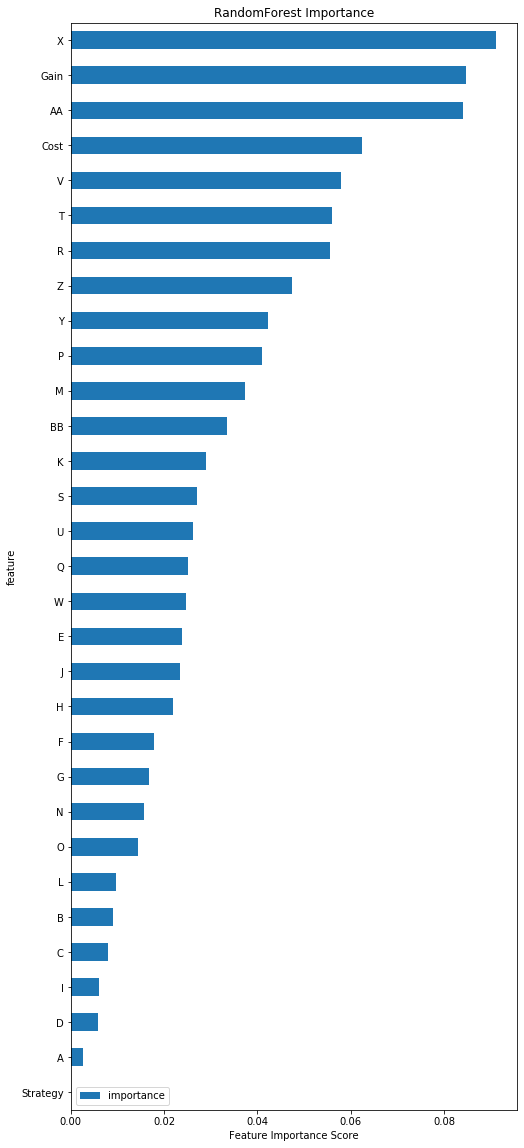

In [133]:
# Feature Importance according to Random Forest 
feat_imp = pd.DataFrame({'importance':clf.feature_importances_})    
feat_imp['feature'] = X_train.columns
feat_imp.sort_values(by='importance', ascending=True, inplace=True)

feat_imp = feat_imp.set_index('feature', drop=True)
feat_imp.plot.barh(title= 'RandomForest Importance', figsize=(8,20))
plt.xlabel('Feature Importance Score')
plt.show()


In [148]:
# Getting the clents which received strategy 1

df1 = df[df.Strategy == 1]

#
X_train, X_test = train_test_split( df1, test_size=0.33, random_state=42)
Y_train = X_train.Success       
Y_test= X_test.Success       
X_train=X_train.drop(columns=['Success', 'Day'])
X_test= X_test.drop(columns=['Success', 'Day'])


#Fit the classifer
clf1 = RandomForestClassifier(n_estimators=100, random_state=5, min_samples_split =5, min_samples_leaf= 5)
clf1.fit(X_train, Y_train)
print(classification_report(Y_test, clf1.predict(X_test)))
print(classification_report(Y_train, clf1.predict(X_train)))

              precision    recall  f1-score   support

           0       0.90      0.93      0.91       210
           1       0.89      0.85      0.87       149

    accuracy                           0.90       359
   macro avg       0.90      0.89      0.89       359
weighted avg       0.90      0.90      0.90       359

              precision    recall  f1-score   support

           0       0.97      1.00      0.98       417
           1       0.99      0.96      0.98       309

    accuracy                           0.98       726
   macro avg       0.98      0.98      0.98       726
weighted avg       0.98      0.98      0.98       726



In [150]:
# Getting the clents which received strategy 2

df2 = df[df.Strategy == 2]

#
X_train, X_test = train_test_split( df2, test_size=0.33, random_state=42)
Y_train = X_train.Success       
Y_test= X_test.Success       
X_train=X_train.drop(columns=['Success', 'Day'])
X_test= X_test.drop(columns=['Success', 'Day'])


#Fit the classifer
clf2 = RandomForestClassifier(n_estimators=100, random_state=5, min_samples_split =5, min_samples_leaf= 5)
clf2.fit(X_train, Y_train)
print(classification_report(Y_test, clf2.predict(X_test)))
print(classification_report(Y_train, clf2.predict(X_train)))

              precision    recall  f1-score   support

           0       0.78      0.93      0.85       229
           1       0.88      0.65      0.74       167

    accuracy                           0.81       396
   macro avg       0.83      0.79      0.80       396
weighted avg       0.82      0.81      0.81       396

              precision    recall  f1-score   support

           0       0.94      0.99      0.96       503
           1       0.97      0.89      0.93       299

    accuracy                           0.95       802
   macro avg       0.96      0.94      0.95       802
weighted avg       0.95      0.95      0.95       802



In [155]:
# Save the models 
with open('clf0.pickle', 'wb') as handle:
    pickle.dump(clf0, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('clf1.pickle', 'wb') as handle:
    pickle.dump(clf1, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('clf2.pickle', 'wb') as handle:
    pickle.dump(clf2, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [ ]:
#Some descriptive statistics

print(len(df[df.Success == 0])/len(df.Success))

print(len(train[train.Success == 0])/len(train.Success))

#print(len(train.where((train.Success == 0) & (train.Strategy == 0) ))/len(train.Success))
#print(len(train.where((train.Success == 0) & (train.Strategy == 1) ))/len(train.Success))

print(len(train[train.Strategy == 0])/len(train.Success))
print(len(train[train.Day == 1])/len(train.Success))
print(len(train[train.Day == 2])/len(train.Success))
print(len(train[train.Strategy == 1])/len(train.Success))

